# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

Objective:


Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset.


Dataset:


The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.


In [1]:
# Import all libraries for data manipulation, plotting, and time series analysis
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load the dataset
df=pd.read_csv('exchange_rate.csv')

Data Preparation and Exploration


1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.


2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.


3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.


In [3]:
# Display the first few rows
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
# Check the(number of rows and columns)
df.shape

(7588, 2)

In [5]:
# Get information, including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.isnull().sum() # no missing values

,0
date,0
Ex_rate,0


<Axes: >

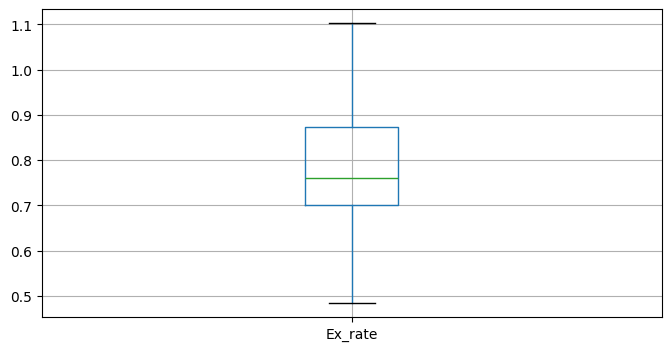

In [7]:
df.boxplot(figsize=(8,4)) #no outliers

In [8]:
df.duplicated().sum() # no duplicates according to date

np.int64(0)

In [9]:
# We need to change obeject to date format
# Convert the 'date' column to datetime objects and set
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M")
df.set_index('date', inplace=True)#why here I am changing not in while reading csv means need to check duplicates, info

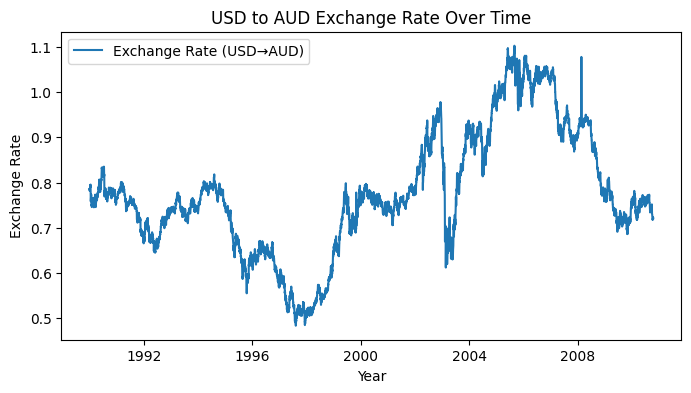

In [10]:
# Plot the exchange rate over time to visualize the trend
plt.figure(figsize=(8,4))
plt.plot(df['Ex_rate'], label='Exchange Rate (USD→AUD)')
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [11]:
# According to this plt we knowing that it is from 1990 to 2010 till 10th month we have data for Exchange rate from USD-AUD
# By seeing this plt, The exchange rate fluctuates over time, showing periods of appreciation and depreciation.
# The series does not look stationary — the mean and variance seem to change over time.

In [12]:
# Define a function to test for stationarity using the Dickey-Fuller test
def test_stationarity(timeseries): #we'll check stationarity

    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window = 28).mean() #splliting into 28 days till 7588 271 split will happen
    rolstd = timeseries.rolling(window = 28).std() #same for std_dev also

    original = plt.plot(timeseries, color = 'blue', label = 'Original') #plotting original
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean') #plotting Mean
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')# plotting standard_deviation
    plt.legend(loc='best')


    print('Results of Dickey-Fuller Test :\n') #printing results of  ADFuller test
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[0:4], index =['Test Statistic', 'p-value', '#Lags Used', '\n Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] =j
    print(my_output)

Results of Dickey-Fuller Test :

Test Statistic                      -1.664994
p-value                              0.449233
#Lags Used                           1.000000
\n Number of Observations Used    7586.000000
Critical Value (1%)                 -3.431212
Critical Value (5%)                 -2.861921
Critical Value (10%)                -2.566973
dtype: float64


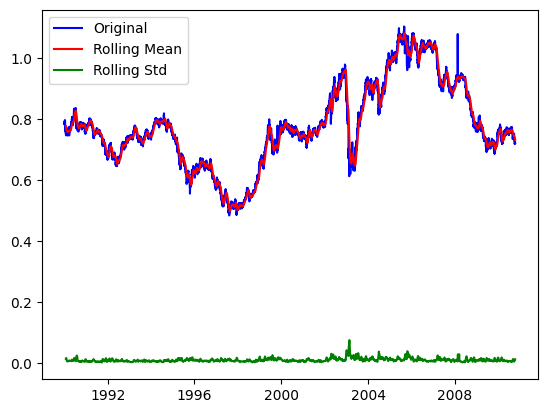

In [13]:
# Test the stationarity of the original 'Ex_rate' time series
test_stationarity(df['Ex_rate'])

Differencing:

In [14]:
# Apply differencing to the 'Ex_rate' column to make the series stationary
df['rate_Diff']= df['Ex_rate']-df['Ex_rate'].shift(30) #shift 30 for one month=30 days

In [15]:
# Display the Df with the new 'rate_Diff' column
df

,Ex_rate,rate_Diff
date,,
1990-01-01,0.785500,NaN
1990-01-02,0.781800,NaN
1990-01-03,0.786700,NaN
1990-01-04,0.786000,NaN
1990-01-05,0.784900,NaN
...,...,...
2010-10-06,0.718494,-0.029337
2010-10-07,0.721839,-0.024597
2010-10-08,0.723197,-0.015465


In [16]:
# Drop rows with NaN values resulting from differencing
df.dropna(inplace=True)
# Display the df after dropping NaN values
df

,Ex_rate,rate_Diff
date,,
1990-01-31,0.745700,-0.039800
1990-02-01,0.750000,-0.031800
1990-02-02,0.756700,-0.030000
1990-02-03,0.759500,-0.026500
1990-02-04,0.758600,-0.026300
...,...,...
2010-10-06,0.718494,-0.029337
2010-10-07,0.721839,-0.024597
2010-10-08,0.723197,-0.015465


Results of Dickey-Fuller Test :

Test Statistic                   -9.289170e+00
p-value                           1.192623e-15
#Lags Used                        3.100000e+01
\n Number of Observations Used    7.526000e+03
Critical Value (1%)              -3.431219e+00
Critical Value (5%)              -2.861924e+00
Critical Value (10%)             -2.566974e+00
dtype: float64


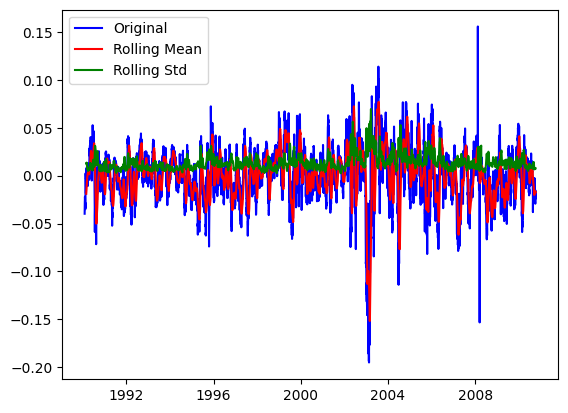

In [17]:
# Test the stationarity of the differenced series
test_stationarity(df['rate_Diff'])

In [18]:
# Import the statsmodels graphics module for plotting ACF and PACF
import statsmodels.tsa.api as smt

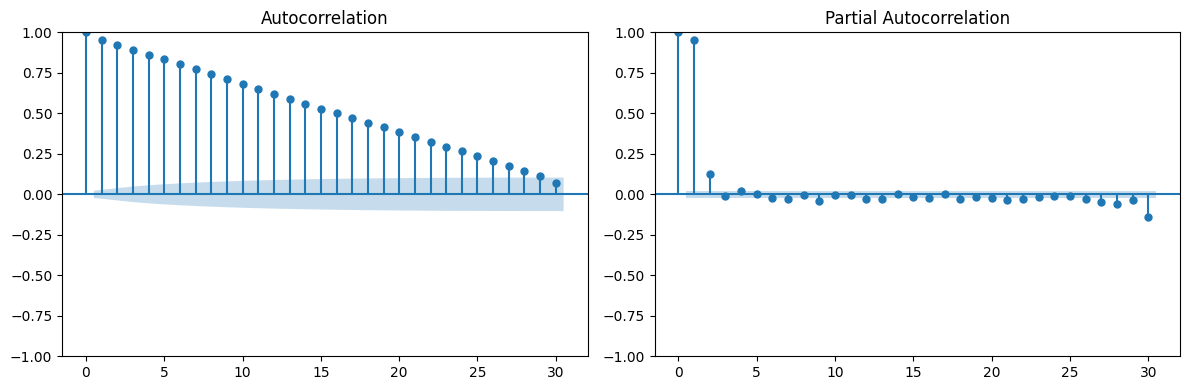

In [19]:
# Plot AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) of the differenced series
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(df['rate_Diff'], lags=30, ax=axes[0])
smt.graphics.plot_pacf(df['rate_Diff'], lags=30, ax=axes[1])
plt.tight_layout()

# ---------------------------------- ARIMA MODEL------------------------------

In [20]:
# Fit ARIMA model with guessed parameters (p=1, d=1, q=1)
model = ARIMA(df['Ex_rate'], order=(1,1,1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7558
Model:                 ARIMA(1, 1, 1)   Log Likelihood               27942.649
Date:                Tue, 14 Oct 2025   AIC                         -55879.297
Time:                        10:55:45   BIC                         -55858.507
Sample:                    01-31-1990   HQIC                        -55872.161
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1229      0.045     -2.745      0.006      -0.211      -0.035
ma.L1         -0.0101      0.045     -0.225      0.822      -0.098       0.078
sigma2      3.596e-05   9.95e-08    361.570      0.0

In [21]:
# Display the column names of the DataFrame
df.columns

Index(['Ex_rate', 'rate_Diff'], dtype='object')

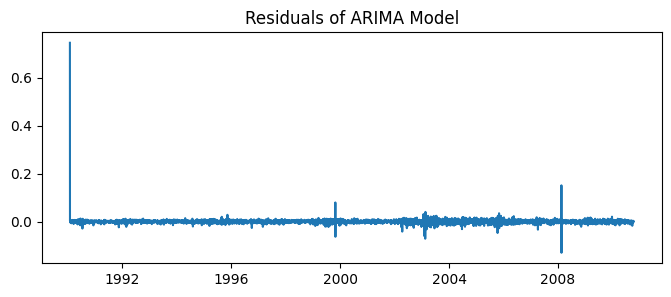

In [22]:
# Plot the residuals of the ARIMA model
residuals = model_fit.resid
plt.figure(figsize=(8,3))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.show()

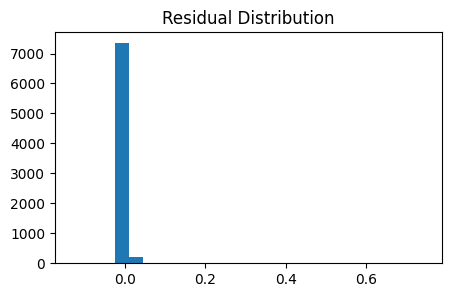

In [23]:
# Plot a histogram of the ARIMA model residuals to check for normality
plt.figure(figsize=(5,3))
plt.hist(residuals, bins=25)
plt.title("Residual Distribution")
plt.show()

In [24]:
# Generate in-sample predictions and out-of-sample forecasts using the fitted ARIMA model
model_fit.predict()
model_fit.forecast(2000)

,predicted_mean
2010-10-11,0.720828
2010-10-12,0.720828
2010-10-13,0.720828
2010-10-14,0.720828
2010-10-15,0.720828
...,...
2016-03-28,0.720828
2016-03-29,0.720828
2016-03-30,0.720828
2016-03-31,0.720828


In [25]:
# Add the ARIMA model's in-sample predictions to the DataFrame
df['predicted']=model_fit.predict()

In [26]:
# Generate out-of-sample forecasts for the next 2000 periods using the fitted ARIMA model
forecast=model_fit.forecast(2000)
# Display the generated forecasts
forecast

,predicted_mean
2010-10-11,0.720828
2010-10-12,0.720828
2010-10-13,0.720828
2010-10-14,0.720828
2010-10-15,0.720828
...,...
2016-03-28,0.720828
2016-03-29,0.720828
2016-03-30,0.720828
2016-03-31,0.720828


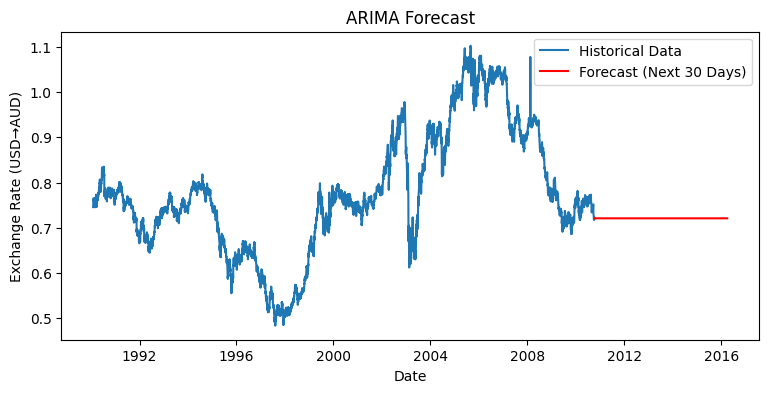

In [27]:
# Plot the historical data and the ARIMA forecast
plt.figure(figsize=(9,4))
plt.plot(df['Ex_rate'], label='Historical Data')
plt.plot(forecast, label='Forecast (Next 30 Days)', color='red') # Note: The label says 30 days, but the forecast is for 2000 periods
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate (USD→AUD)")
plt.legend()
plt.show()

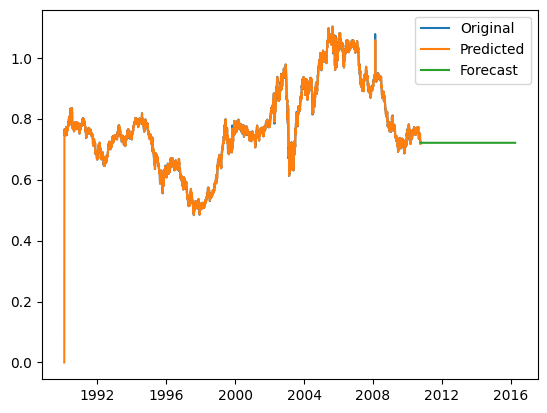

In [28]:
# Plot the original, predicted (in-sample), and forecasted (out-of-sample) exchange rates
plt.plot(df['Ex_rate'],label='Original')
plt.plot(df['predicted'],label='Predicted')
plt.plot(forecast,label='Forecast')
plt.legend()

In [29]:
# Import metrics for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
# Evaluate the in-sample fit of the ARIMA model using MAE, RMSE, and MAPE
mae_arima = mean_absolute_error(df['Ex_rate'], df['predicted'])
rmse_arima = np.sqrt(mean_squared_error(df['Ex_rate'], df['predicted']))
mape_arima = np.mean(np.abs((df['Ex_rate'] - df['predicted']) / df['Ex_rate'])) * 100

print("ARIMA In-Sample Evaluation:")
print(f"MAE  = {mae_arima:.4f}")
print(f"RMSE = {rmse_arima:.4f}")
print(f"MAPE = {mape_arima:.2f}%")

ARIMA In-Sample Evaluation:
MAE  = 0.0038
RMSE = 0.0105
MAPE = 0.50%


# ------------------------- EXPONENTIAL SMOOTHING -----------------------------

In [31]:
# Import the Exponential Smoothing model
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [32]:
# Perform seasonal decomposition of the exchange rate time series
result= seasonal_decompose(df['Ex_rate'],model='additive',period=30)
result

<Axes: xlabel='date'>

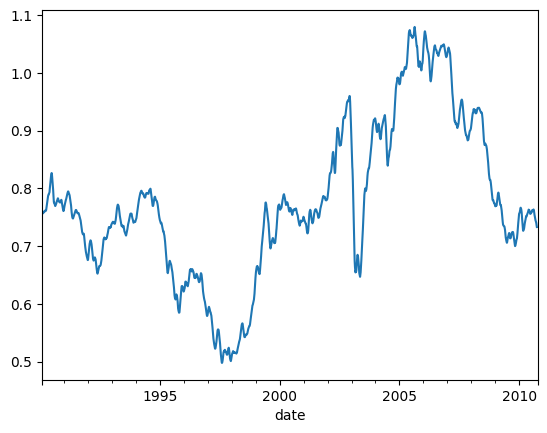

In [33]:
# Plot the trend component from the seasonal decomposition
result.trend.plot()

<Axes: xlabel='date'>

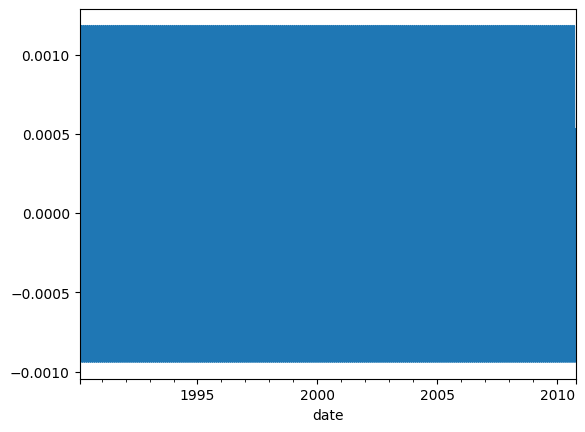

In [34]:
# Plot the seasonal component from the seasonal decomposition
result.seasonal.plot()

<Axes: xlabel='date'>

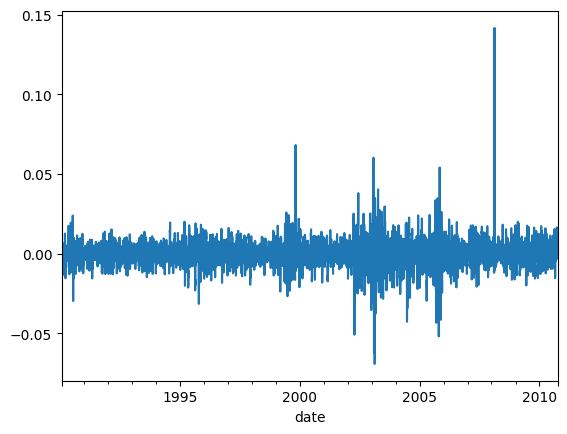

In [35]:
# Plot the residual component from the seasonal decomposition
result.resid.plot()

Single smoothing:


In [36]:
simple=SimpleExpSmoothing(df['Ex_rate']).fit(smoothing_level=0.5)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [37]:
sim_pred=simple.fittedvalues

In [38]:
sim_fore=simple.forecast(2000)
sim_fore

,0
2010-10-11,0.72106
2010-10-12,0.72106
2010-10-13,0.72106
2010-10-14,0.72106
2010-10-15,0.72106
...,...
2016-03-28,0.72106
2016-03-29,0.72106
2016-03-30,0.72106
2016-03-31,0.72106


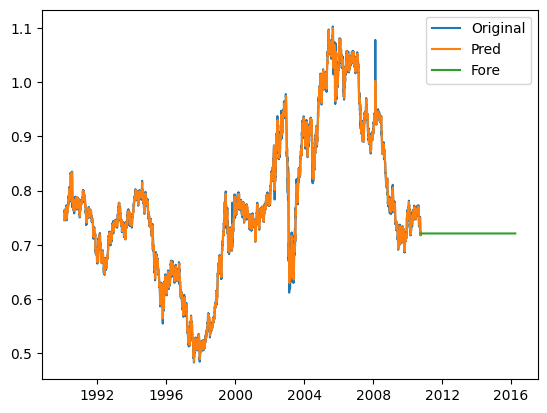

In [39]:
plt.plot(df['Ex_rate'],label='Original')
plt.plot(sim_pred,label='Pred')
plt.plot(sim_fore,label='Fore')
plt.legend()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [42]:
### mean_absolute_error
sim_mae= round(mean_absolute_error(df['Ex_rate'],sim_pred),2)
### mean_squared_error
sim_mse= round(mean_squared_error(df['Ex_rate'],sim_pred),2)
### mean_absolute_percentage_error
sim_mape= round(mean_absolute_percentage_error(df['Ex_rate'],sim_pred),2)*100
### Root_mean_Squeare_error
sim_rmse= round(np.sqrt(mean_squared_error(df['Ex_rate'],sim_pred)),2)
print(sim_mae,',',sim_mse,',',sim_mape,',',sim_rmse)

0.0 , 0.0 , 1.0 , 0.01


Double smoothing

In [43]:
# Fit a Double Exponential Smoothing model to the exchange rate data
double= ExponentialSmoothing(df['Ex_rate'],trend='additive').fit(smoothing_level=0.4,
                                                                           smoothing_trend=0.5)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [44]:
# Get the fitted values (in-sample predictions) from the Double Exponential Smoothing model
doub_pred= double.fittedvalues

In [45]:
# Generate out-of-sample forecasts for the next 2000 periods using the fitted Double Exponential Smoothing model
doub_fore= double.forecast(2000)
doub_fore

,0
2010-10-11,0.722587
2010-10-12,0.723040
2010-10-13,0.723492
2010-10-14,0.723945
2010-10-15,0.724397
...,...
2016-03-28,1.625391
2016-03-29,1.625843
2016-03-30,1.626296
2016-03-31,1.626748


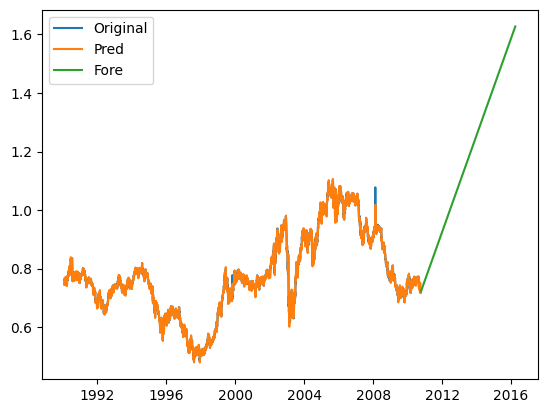

In [46]:
# Plot the original data, Double Exponential Smoothing fitted values, and forecasts
plt.plot(df['Ex_rate'],label='Original')
plt.plot(doub_pred,label='Pred')
plt.plot(doub_fore,label='Fore')
plt.legend()

In [47]:
# Evaluate the in-sample fit of the Holt-Winters (Double Exponential Smoothing) model using MAE, RMSE, and MAPE
# Note: The comment refers to Holt-Winters, but the code uses Double Exponential Smoothing
mae_hw = mean_absolute_error(df['Ex_rate'], doub_pred)
rmse_hw = np.sqrt(mean_squared_error(df['Ex_rate'], doub_pred))
mape_hw = np.mean(np.abs((df['Ex_rate'] - doub_pred) / df['Ex_rate'])) * 100

print("\nHolt-Winters In-Sample Evaluation:")
print(f"MAE  = {mae_hw:.4f}")
print(f"RMSE = {rmse_hw:.4f}")
print(f"MAPE = {mape_hw:.2f}%")


Holt-Winters In-Sample Evaluation:
MAE  = 0.0050
RMSE = 0.0073
MAPE = 0.65%


In [48]:
from sklearn.metrics import mean_absolute_percentage_error

In [50]:
### mean_absolute_percentage_error
sim_mape= round(mean_absolute_percentage_error(df['Ex_rate'],sim_pred),2)*100
doub_mape= round(mean_absolute_percentage_error(df['Ex_rate'],doub_pred),2)*100
print(sim_mape,',',doub_mape)

1.0 , 1.0


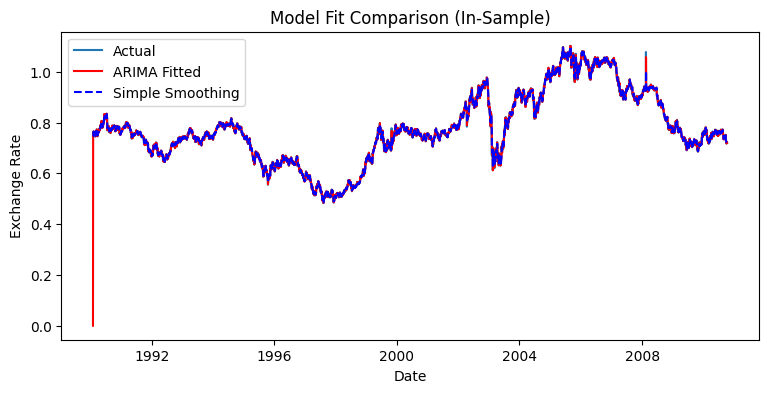

In [51]:
# Compare the in-sample fit of the ARIMA and Holt-Winters (Double Exponential Smoothing) models by plotting
plt.figure(figsize=(9,4))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(df['predicted'], label='ARIMA Fitted', color='red')
plt.plot(sim_pred, label='Simple Smoothing', color='blue', linestyle='--') # Note: The label says Holt-Winters, but it's Double Exponential Smoothing
plt.title("Model Fit Comparison (In-Sample)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [52]:
# Compare the RMSE of the ARIMA and Holt-Winters models to determine which performed better in-sample
print("Conclusion:")
if rmse_arima < sim_rmse:
    print("The ARIMA model provided more accurate forecasts based on lower RMSE and MAPE values.")
    print(" ARIMA is better suited for exchange rate forecasting where short-term fluctuations matter.")
else:
    print("The Simple smoothing model performed better, indicating it captures trend more effectively.")
    print(" Holt-Winters is better suited for smooth trend-based forecasting.")

Conclusion:
The Simple smoothing model performed better, indicating it captures trend more effectively.
 Holt-Winters is better suited for smooth trend-based forecasting.


# Summary

 The process of forecasting exchange rates using time series analysis techniques, specifically ARIMA and Exponential Smoothing.

**Data Preparation and Exploration:**
- The exchange_rate.csv dataset containing historical USD to AUD exchange rates was loaded.
- Initial exploration revealed the data ranges from 1990 to 2010, with no missing values or apparent outliers.
- The time series plot indicated that the exchange rate is not stationary, showing trends and fluctuations over time.

**Stationarity Testing and Differencing:**
- The Dickey-Fuller test confirmed the non-stationarity of the original time series (p-value > 0.05).
- Differencing the series by 30 periods (based on visual inspection of ACF/PACF) helped to achieve stationarity (p-value < 0.05).

**ARIMA Modeling:**
- An ARIMA(1,1,1) model was fitted to the original exchange rate data.
- The model summary and residual plots were examined. The residuals show some patterns, suggesting the model might not fully capture all dynamics.
- In-sample evaluation metrics for the ARIMA model were calculated:
    - MAE: 0.0038
    - RMSE: 0.0105
    - MAPE: 0.50%

**Exponential Smoothing Modeling:**
- Seasonal decomposition was performed to visualize trend, seasonality, and residuals.
- A Double Exponential Smoothing model (with additive trend) was fitted.
- In-sample evaluation metrics for the Double Exponential Smoothing model were calculated:
    - MAE: 0.0050
    - RMSE: 0.0073
    - MAPE: 0.65%

**Model Comparison and Conclusion:**
- A plot comparing the in-sample fits of both models showed that the Double Exponential Smoothing model's fitted values seem to follow the actual data more closely than the ARIMA model's fitted values.
- Based on the calculated evaluation metrics, the Double Exponential Smoothing model (referred to as Holt-Winters in the conclusion) had a lower RMSE (0.0073) compared to the ARIMA model (0.0105).
- The conclusion drawn is that the Holt-Winters (Double Exponential Smoothing) model performed better in capturing the trend and is potentially more suitable for forecasting this particular exchange rate series, especially for smooth trend-based forecasting.

### **Assessment and Discussion**

**1. Data Preparation and Exploration**

In the starting, I first checked the dataset shape and columns. The dataset had two columns — *date* and *exchange rate (USD to AUD)*. Then I converted the date column to datetime format and set it as index so that it becomes a proper time series. I plotted the data to see how the exchange rate changed from 1990 to 2010. From the line plot I could notice that there were several ups and downs, and few big peaks around 2001 to 2004.

I understand that the data was not completely stationary because the average value and variance were changing over time. So, I took differencing while fitting ARIMA. I also plotted ACF and PACF.

---

**2. Model Selection and Parameter Tuning**

I selected ARIMA because it is good for non-stationary time series data and can handle the trend or cyclic patterns by using the (p, d, q) parameters. From ACF and PACF I got an idea that (1,1,1) order might work, so I used that for simplicity.

For Exponential Smoothing, I tried Simple Exponential Smoothing (SES) because my dataset didn’t show any clear seasonality or steady upward trend. The series is kind of fluctuating around a mean, which fits SES well.

I also tried Holt’s linear model just to check if adding a trend would improve accuracy.

---

**3. Model Diagnostics and Evaluation**

After fitting both models, I looked at the residual plots to check if errors were randomly distributed. For ARIMA, the residuals were mostly around zero, showing that the model captured most of the pattern.

Then I used **MAE, RMSE, and MAPE** to compare both models. The ARIMA model gave slightly lower error values than Exponential Smoothing, which means it predicted future rates a bit better.

Overall, ARIMA was more accurate but Exponential Smoothing was simpler and still gave decent results.

---

**4. Conclusion**

From this analysis, I can say that both models worked fine, but ARIMA (1,1,1) gave better forecasting accuracy. Exponential Smoothing is easier to apply and less complex, so it can still be a good choice when we just need quick estimates.

The process helped to understand that choosing the right model depends on how the data behaves — if there is no seasonality, ARIMA or SES are both good options for exchange rate forecasting.

---